In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import mutual_info_classif
import xgboost as xgb
from lightgbm import LGBMClassifier

import keras
from numpy import array
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


**Concatinate train and test to make some data precessing and cleaning before splitting**

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/code/UNSW_NB15_testing-set.csv")
df_test = pd.read_csv("/content/drive/MyDrive/code/UNSW_NB15_training-set.csv")
df = pd.concat([df_train, df_test])
# information about the dataset
pd.set_option('display.max_columns', None)
df

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,1.415894e+04,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8.395112e+03,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1.572272e+03,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,252,2.740179e+03,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,252,8.561499e+03,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,82328,0.000005,udp,-,INT,2,0,104,0,200000.005100,254,0,8.320000e+07,0.000000,0,0,0.005000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,52,0,0,0,1,2,2,1,1,2,0,0,0,2,1,0,Normal,0
82328,82329,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,254,252,1.241044e+05,2242.109863,7,1,55.880051,143.700000,4798.130981,190.980813,255,1072535109,3284291478,255,0.173208,0.100191,0.073017,903,44,0,0,1,1,2,1,1,1,0,0,0,3,2,0,Normal,0
82329,82330,0.000000,arp,-,INT,1,0,46,0,0.000000,0,0,0.000000e+00,0.000000,0,0,60000.720000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,46,0,0,0,1,2,1,1,1,1,0,0,0,1,1,1,Normal,0
82330,82331,0.000000,arp,-,INT,1,0,46,0,0.000000,0,0,0.000000e+00,0.000000,0,0,60000.732000,0.000000,10.954518,0.000000,0,0,0,0,0.000000,0.000000,0.000000,46,0,0,0,1,2,1,1,1,1,0,0,0,1,1,1,Normal,0


**Get all Data with "Backdoor Attack"
and get 2329 Normal data as the same number as the Backdoor Attack**

In [ ]:
# Filter the DataFrame to include only "Backdoor" and "Normal" rows
backdoor_data = df[df['attack_cat'] == 'Backdoor']
normal_data = df[df['attack_cat'] == 'Normal']

# Randomly sample 2329 rows from the "Normal" category
sampled_normal_data = normal_data.sample(n=2329, random_state=42)  # You can adjust the random_state if needed

# Combine the "Backdoor" and sampled "Normal" data
balanced_data = pd.concat([backdoor_data, sampled_normal_data])

# Shuffle the balanced data
balanced_data_shuffled = balanced_data.sample(frac=1, random_state=42)  # Shuffle with random_state for reproducibility
unique_sttl_values = balanced_data_shuffled['state'].unique()
unique_sttl_values

array(['INT', 'FIN', 'CON', 'REQ', 'RST'], dtype=object)

**Check Any missing Value**

In [ ]:
# Check for missing values in the dataset
missing_values = balanced_data_shuffled.isnull().sum()
print("Missing values in the dataset:")
print(missing_values)


Missing values in the dataset:
id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_

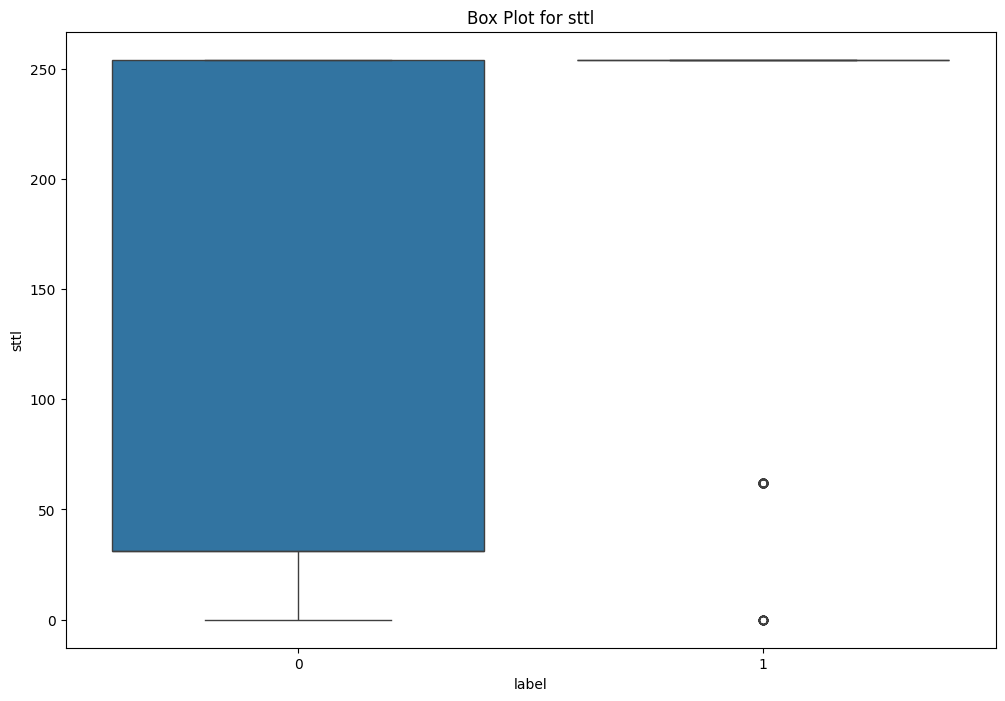

In [ ]:
target_variable = balanced_data_shuffled['label']
plt.figure(figsize=(12, 8))
sns.boxplot(x=target_variable, y=balanced_data_shuffled['sttl'], data=balanced_data_shuffled)
plt.title('Box Plot for sttl')
plt.show()


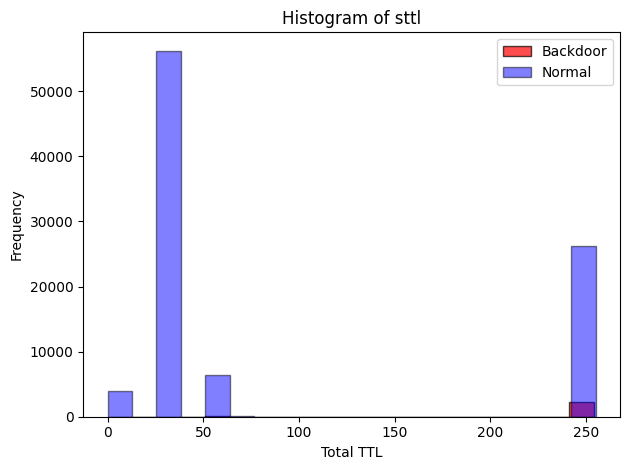

In [ ]:

plt.hist(backdoor_data['sttl'], bins=20, color='red', alpha=0.7, label='Backdoor', edgecolor='black')
plt.hist(normal_data['sttl'], bins=20, color='blue', alpha=0.5, label='Normal', edgecolor='black')
plt.title('Histogram of sttl')
plt.xlabel('Total TTL')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

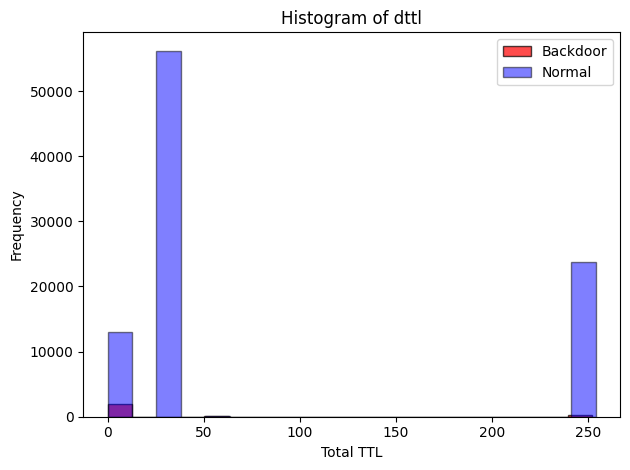

In [ ]:
plt.hist(backdoor_data['dttl'], bins=20, color='red', alpha=0.7, label='Backdoor', edgecolor='black')
plt.hist(normal_data['dttl'], bins=20, color='blue', alpha=0.5, label='Normal', edgecolor='black')
plt.title('Histogram of dttl')
plt.xlabel('Total TTL')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

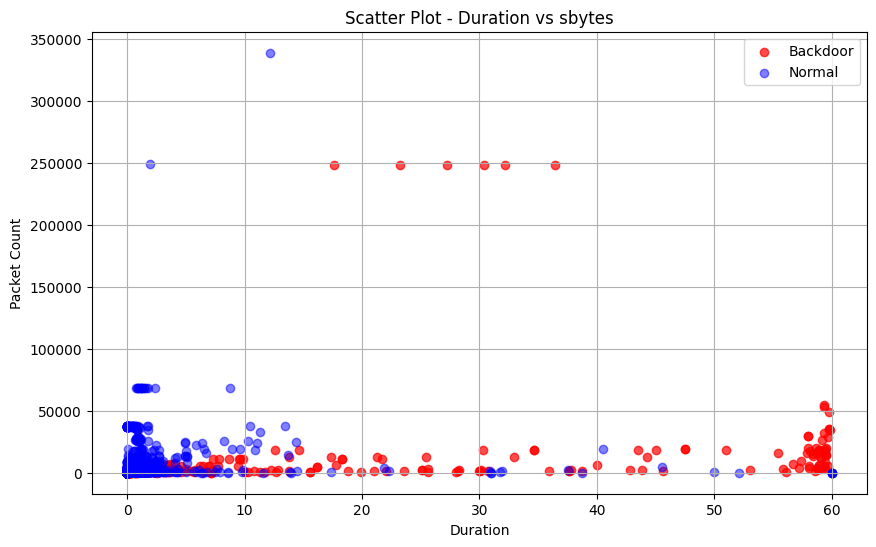

In [ ]:
normal_data = balanced_data_shuffled[balanced_data_shuffled['label'] == 0]
backdoor_data = balanced_data_shuffled[balanced_data_shuffled['label'] == 1]
# Scatter plot for Duration vs Packet Count
plt.figure(figsize=(10, 6))

# Backdoor traffic
plt.scatter(backdoor_data['dur'], backdoor_data['sbytes'], color='red', label='Backdoor', alpha=0.7)

# Normal traffic
plt.scatter(normal_data['dur'], normal_data['sbytes'], color='blue', label='Normal', alpha=0.5)

plt.title('Scatter Plot - Duration vs sbytes')
plt.xlabel('Duration')
plt.ylabel('Packet Count')
plt.legend()
plt.grid(True)
plt.show()

['unas' 'nvp' 'ddx' 'pup' 'tcp' 'irtp' 'idpr' 'bna' 'ospf' 'sctp' 'snp'
 'vmtp' 'cpnx' 'a/n' 'any' 'zero' 'ip' 'leaf-1' 'kryptolan' 'compaq-peer'
 'ipcv' 'aes-sp3-d' 'pim' 'i-nlsp' 'ippc' 'mtp' 'sat-mon' 'hmp' 'xnet'
 'qnx' 'udp' 'ipx-n-ip' 'gre' 'wsn' 'uti' 'pipe' 'narp' 'argus' 'ipv6-no'
 'ib' 'xtp' 'emcon' 'vrrp' 'igp' 'tp++' 'iso-ip' 'cphb' 'ipnip' 'encap'
 'etherip' 'ipv6-route' 'l2tp' 'crudp' 'trunk-1' 'rvd' 'sat-expak'
 'mobile' 'prm' 'eigrp' 'rsvp' 'pgm' 'merit-inp' 'sdrp' 'sep' 'ipv6'
 'ax.25' 'smp' 'sun-nd' 'iplt' 'netblt' 'fire' 'isis' 'wb-expak' 'srp'
 'idrp' 'rdp' 'trunk-2' 'ipip' 'skip' 'sprite-rpc' 'bbn-rcc' 'ipv6-opts'
 'visa' 'dgp' 'mhrp' 'leaf-2' 'iatp' 'br-sat-mon' 'iso-tp4' 'cftp' 'ddp'
 'pnni' 'nsfnet-igp' 'sps' 'chaos' 'sccopmce' 'secure-vmtp' 'ggp' 'scps'
 'dcn' 'tcf' 'tlsp' 'wb-mon' 'crtp' '3pc' 'stp' 'swipe' 'cbt' 'sm' 'pvp'
 'ttp' 'egp' 'ipcomp' 'ptp' 'larp' 'ipv6-frag' 'idpr-cmtp' 'st2' 'vines'
 'fc' 'aris' 'mux' 'pri-enc' 'gmtp' 'micp' 'ifmp' 'mfe-nsp' 'xns-

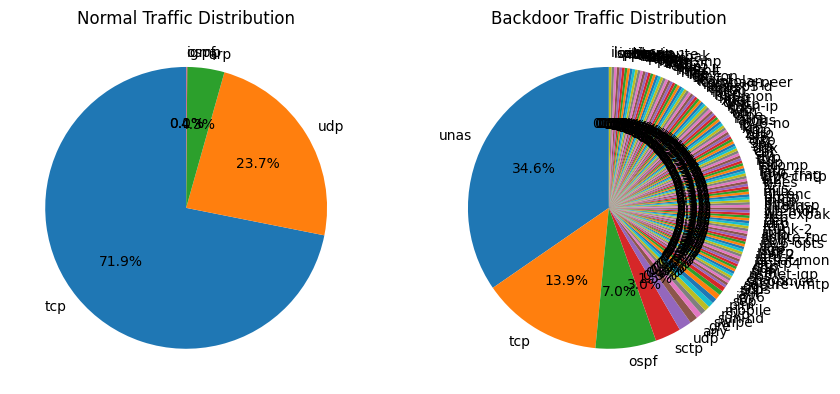

In [ ]:
normal_data = balanced_data_shuffled[balanced_data_shuffled['label'] == 0]['proto'].value_counts()
print ( balanced_data_shuffled[balanced_data_shuffled['label'] == 1]['proto'].unique())
backdoor_data = balanced_data_shuffled[balanced_data_shuffled['label'] == 1]['proto'].value_counts()

# Calculate percentages
total_normal = normal_data.sum()
normal_percentages = [(count / total_normal) * 100 for count in normal_data]

total_backdoor = backdoor_data.sum()
backdoor_percentages = [(count / total_backdoor) * 100 for count in backdoor_data]

# Create Pie Charts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Pie chart for Normal Traffic
axes[0].pie(normal_percentages, labels=normal_data.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Normal Traffic Distribution')

# Pie chart for Backdoor Traffic
axes[1].pie(backdoor_percentages, labels=backdoor_data.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Backdoor Traffic Distribution')

plt.show()


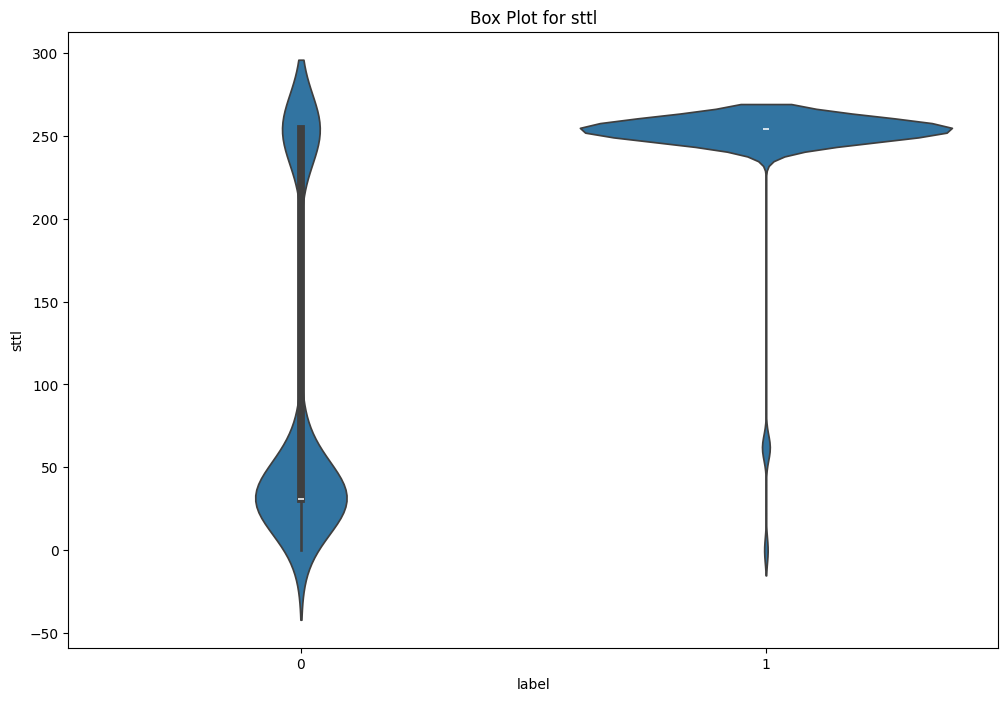

In [ ]:
target_variable = balanced_data_shuffled['label']
plt.figure(figsize=(12, 8))
sns.violinplot(x=target_variable, y=balanced_data_shuffled['sttl'], data=balanced_data_shuffled)
plt.title('Box Plot for sttl')
plt.show()


In [ ]:
unique_sttl_values = balanced_data_shuffled['ackdat'].unique()
unique_sttl_values

array([0.      , 0.000129, 0.000161, ..., 0.06085 , 0.054865, 0.125041])

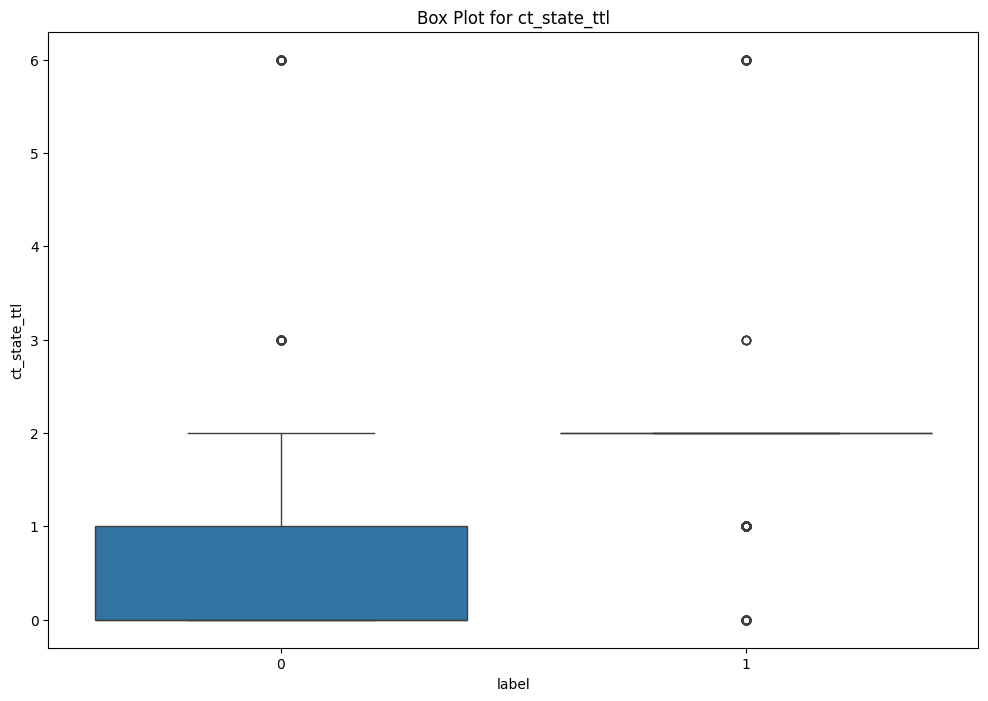

In [ ]:
target_variable = balanced_data_shuffled['label']
plt.figure(figsize=(12, 8))
sns.boxplot(x=target_variable, y=balanced_data_shuffled['ct_state_ttl'], data=balanced_data_shuffled)
plt.title('Box Plot for ct_state_ttl')
plt.show()


In [ ]:
unique_sttl_values = balanced_data_shuffled['state'].unique()
unique_sttl_values

array(['INT', 'FIN', 'CON', 'REQ', 'RST'], dtype=object)

In [ ]:
df.columns

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')

In [ ]:
import pandas as pd
import statsmodels.api as sm

# Assuming your DataFrame is named 'df'
# Replace 'YourColumnName' with the actual column names in your DataFrame

# Select the columns of interest
selected_columns = ['state', 'sttl', 'dttl', 'ct_state_ttl']

# Create a new DataFrame with only the selected columns
selected_df = balanced_data_shuffled[selected_columns]

# Convert 'state' column to numeric
selected_df['state'] = pd.to_numeric(selected_df['state'], errors='coerce')

# Encode categorical variable 'state' into numerical values
selected_df = pd.get_dummies(selected_df, columns=['state'], prefix='state', drop_first=True)

# Convert all columns to numeric, handle any non-numeric values
selected_df = selected_df.apply(pd.to_numeric, errors='coerce')

# Drop rows with missing values
selected_df = selected_df.dropna()

# Add a constant term for the intercept
selected_df = sm.add_constant(selected_df)

# Separate independent variables (X) and dependent variable (y)
X = selected_df.drop('ct_state_ttl', axis=1)  # Exclude the dependent variable
y = selected_df['ct_state_ttl']

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           ct_state_ttl   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     2074.
Date:                Wed, 01 May 2024   Prob (F-statistic):               0.00
Time:                        05:39:41   Log-Likelihood:                -5835.8
No. Observations:                4658   AIC:                         1.168e+04
Df Residuals:                    4655   BIC:                         1.170e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2183      0.024      9.100      0.0

<ipython-input-20-0718612f28ea>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['state'] = pd.to_numeric(selected_df['state'], errors='coerce')


**Drop unecessary Features**

In [ ]:
# # Drop features that don't belong to the "Backdoor" attack category
# balanced_data_shuffled =  balanced_data_shuffled.drop(['swin', 'dwin', 'stcpb', 'dtcpb',
#            'trans_depth', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports',
#            'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd',
#            'attack_cat','id'], axis=1)
# balanced_data_shuffled.info()
# Drop features that don't belong to the "Backdoor" attack category
balanced_data_shuffled =  balanced_data_shuffled.drop(['attack_cat','id'], axis=1)
balanced_data_shuffled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4658 entries, 109826 to 90614
Data columns (total 43 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dur                4658 non-null   float64
 1   proto              4658 non-null   object 
 2   service            4658 non-null   object 
 3   state              4658 non-null   object 
 4   spkts              4658 non-null   int64  
 5   dpkts              4658 non-null   int64  
 6   sbytes             4658 non-null   int64  
 7   dbytes             4658 non-null   int64  
 8   rate               4658 non-null   float64
 9   sttl               4658 non-null   int64  
 10  dttl               4658 non-null   int64  
 11  sload              4658 non-null   float64
 12  dload              4658 non-null   float64
 13  sloss              4658 non-null   int64  
 14  dloss              4658 non-null   int64  
 15  sinpkt             4658 non-null   float64
 16  dinpkt             4658

Shuffel

In [ ]:
balanced_data_shuffled['service'].unique() #Here, we'll deal with the type of service that is '-'
balanced_data_shuffled['service']= np.where(balanced_data_shuffled['service'] == '-', 'None', balanced_data_shuffled['service'])
print(balanced_data_shuffled['service'].unique())


['None' 'dns' 'ftp' 'smtp' 'http' 'ftp-data' 'irc' 'ssh']


In [ ]:
balanced_data_shuffled['proto'].unique() #This is definitely a categorical feature.

array(['unas', 'tcp', 'nvp', 'udp', 'arp', 'ddx', 'pup', 'irtp', 'idpr',
       'bna', 'ospf', 'sctp', 'snp', 'vmtp', 'cpnx', 'a/n', 'any', 'zero',
       'ip', 'leaf-1', 'kryptolan', 'compaq-peer', 'ipcv', 'aes-sp3-d',
       'pim', 'i-nlsp', 'ippc', 'mtp', 'sat-mon', 'hmp', 'xnet', 'qnx',
       'ipx-n-ip', 'gre', 'wsn', 'uti', 'pipe', 'narp', 'argus',
       'ipv6-no', 'ib', 'xtp', 'emcon', 'vrrp', 'igp', 'tp++', 'iso-ip',
       'cphb', 'ipnip', 'encap', 'etherip', 'igmp', 'ipv6-route', 'l2tp',
       'crudp', 'trunk-1', 'rvd', 'sat-expak', 'mobile', 'prm', 'eigrp',
       'rsvp', 'pgm', 'merit-inp', 'sdrp', 'sep', 'ipv6', 'ax.25', 'smp',
       'sun-nd', 'iplt', 'netblt', 'fire', 'isis', 'wb-expak', 'srp',
       'idrp', 'rdp', 'trunk-2', 'ipip', 'skip', 'sprite-rpc', 'bbn-rcc',
       'ipv6-opts', 'visa', 'dgp', 'mhrp', 'leaf-2', 'iatp', 'br-sat-mon',
       'iso-tp4', 'cftp', 'ddp', 'pnni', 'nsfnet-igp', 'sps', 'chaos',
       'sccopmce', 'secure-vmtp', 'ggp', 'scps', 'dcn', 'tc

In [ ]:
balanced_data_shuffled['state'].unique() #Keep it.

array(['INT', 'FIN', 'CON', 'REQ', 'RST'], dtype=object)

In [ ]:
def Remove_dump_values(data, cols):
    for col in cols:
        data[col] = np.where(data[col] == '-', 'None', data[col])
    return data

In [ ]:
cols = balanced_data_shuffled.columns
data_bin = Remove_dump_values(balanced_data_shuffled, cols)

 **I need OneHotEncoding Proto, Service, state**

In [ ]:
df_cat = data_bin.select_dtypes(exclude=[np.number])
from sklearn.preprocessing import LabelEncoder
import joblib

# Assuming df_cat is your DataFrame with categorical columns
for feature in df_cat.columns:
    le = LabelEncoder()
    data_bin[feature] = le.fit_transform(data_bin[feature])

    # Save the LabelEncoder
    encoder_filename = f'{feature}_encoder.joblib'
    joblib.dump(le, encoder_filename)

# Now you can use encoder_filename to load the encoder later

In [ ]:
data_bin.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
109826,2393,118,0,2,20,0,161,0,1015,2,0,762,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,2,17,11,5,33,0,0,0,20,32,0,1
5930,499,111,0,1,16,15,107,133,570,4,2,2100,1876,24,37,560,542,1920,875,1,1262,217,1,33,17,26,245,212,0,0,5,0,28,17,0,1,0,0,0,32,3,0,0
4293,2463,111,0,1,64,60,193,22,757,4,2,1161,285,22,36,922,1746,1653,1355,1,1365,339,1,288,228,58,154,28,0,0,37,0,29,8,0,35,0,0,0,20,3,0,0
50552,2012,76,0,2,20,0,132,0,2466,2,0,2169,0,0,0,11,0,0,0,0,0,0,0,0,0,0,235,0,0,0,38,2,11,8,3,11,0,0,0,11,34,0,1
27365,500,111,0,1,16,15,107,133,569,4,2,2098,1874,24,37,561,544,1919,890,1,33,1069,1,26,16,20,245,212,0,0,35,0,26,17,0,35,0,0,0,32,35,0,0


**Corrolation Matrix**

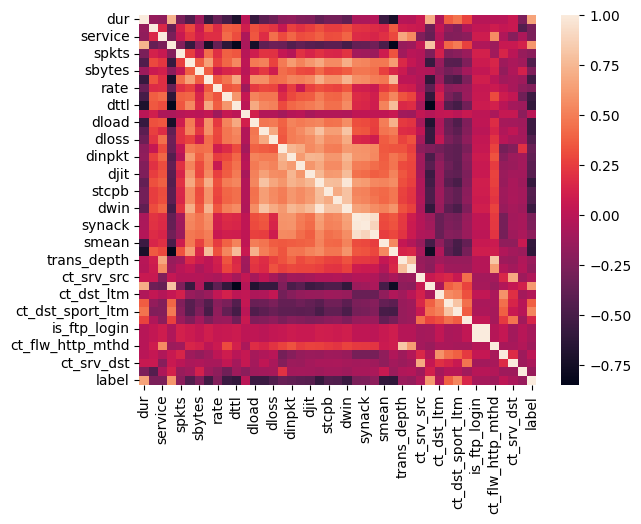

In [ ]:
sns.heatmap(data_bin.corr())
plt.show()

In [ ]:
columns = data_bin.columns.tolist()
corr = data_bin.corr()
correlated_vars = []
for i in range(len(columns) - 1):
    for j in range(i+1, len(columns)):
        if corr[columns[i]][columns[j]] > 0.95:
            print(columns[i], columns[j], corr[columns[i]][columns[j]])
            correlated_vars.append(columns[j])

swin dwin 0.9717936124274676
tcprtt synack 0.9828973866750446
is_ftp_login ct_ftp_cmd 1.0


In [ ]:
data_bin = data_bin.drop(columns=correlated_vars)
data_bin.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4658 entries, 109826 to 90614
Data columns (total 40 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   dur                4658 non-null   int64
 1   proto              4658 non-null   int64
 2   service            4658 non-null   int64
 3   state              4658 non-null   int64
 4   spkts              4658 non-null   int64
 5   dpkts              4658 non-null   int64
 6   sbytes             4658 non-null   int64
 7   dbytes             4658 non-null   int64
 8   rate               4658 non-null   int64
 9   sttl               4658 non-null   int64
 10  dttl               4658 non-null   int64
 11  sload              4658 non-null   int64
 12  dload              4658 non-null   int64
 13  sloss              4658 non-null   int64
 14  dloss              4658 non-null   int64
 15  sinpkt             4658 non-null   int64
 16  dinpkt             4658 non-null   int64
 17  sjit         

**Mutual Information**

In [ ]:
x = data_bin.drop(columns=['label'])
y = data_bin['label']

In [ ]:
mi_scores = mutual_info_classif(x, y)
mi_df = pd.DataFrame(mi_scores, index=x.columns, columns=['MI Score'])
mi_df = mi_df.sort_values(by='MI Score', ascending=False)

print(mi_df)

                   MI Score
sttl               0.331058
dttl               0.291415
ct_state_ttl       0.287386
state              0.277460
dur                0.227842
dbytes             0.207374
ct_dst_sport_ltm   0.200900
swin               0.191062
sloss              0.174709
dmean              0.168844
sbytes             0.164976
smean              0.149499
dload              0.134550
proto              0.113321
dpkts              0.102245
dloss              0.097570
dtcpb              0.093914
djit               0.087154
stcpb              0.086567
ct_src_dport_ltm   0.074734
dinpkt             0.062676
sjit               0.062052
rate               0.049808
spkts              0.049070
service            0.046695
sinpkt             0.039044
response_body_len  0.026294
ct_dst_src_ltm     0.023734
ackdat             0.017528
ct_srv_dst         0.017191
is_sm_ips_ports    0.015194
ct_flw_http_mthd   0.014745
sload              0.013624
trans_depth        0.011103
tcprtt             0

<ipython-input-34-857cbf82e5cd>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MI Score', y=mi_df_sorted.index, data=mi_df_sorted, palette='mako')


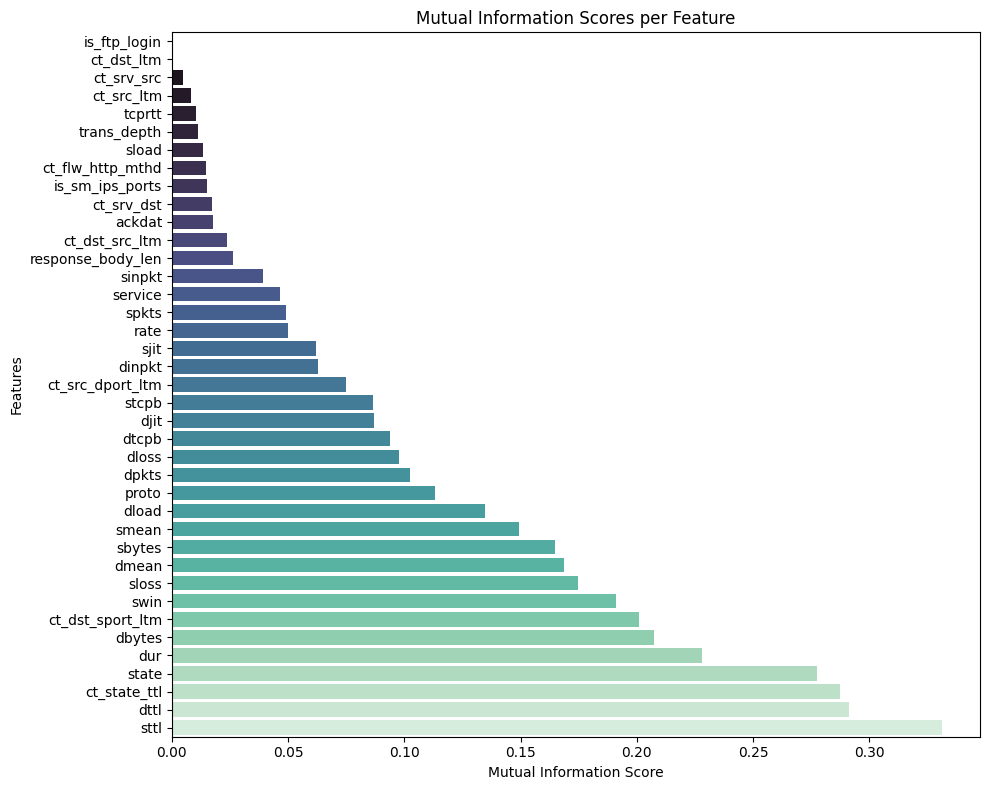

In [ ]:
mi_df_sorted = mi_df.sort_values(by='MI Score', ascending=True)

plt.figure(figsize=(10, 8))
sns.barplot(x='MI Score', y=mi_df_sorted.index, data=mi_df_sorted, palette='mako')
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.title('Mutual Information Scores per Feature')
plt.tight_layout()
plt.show()

In [ ]:
data_bin =  data_bin.drop(['trans_depth','ct_src_ltm','tcprtt','rate','ct_state_ttl'], axis=1)
data_bin.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4658 entries, 109826 to 90614
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   dur                4658 non-null   int64
 1   proto              4658 non-null   int64
 2   service            4658 non-null   int64
 3   state              4658 non-null   int64
 4   spkts              4658 non-null   int64
 5   dpkts              4658 non-null   int64
 6   sbytes             4658 non-null   int64
 7   dbytes             4658 non-null   int64
 8   sttl               4658 non-null   int64
 9   dttl               4658 non-null   int64
 10  sload              4658 non-null   int64
 11  dload              4658 non-null   int64
 12  sloss              4658 non-null   int64
 13  dloss              4658 non-null   int64
 14  sinpkt             4658 non-null   int64
 15  dinpkt             4658 non-null   int64
 16  sjit               4658 non-null   int64
 17  djit         

**Splitting training and testing sets**

In [ ]:
selected_columns = ['dur', 'proto', 'spkts', 'dpkts', 'sbytes', 'dbytes',
       'dload', 'sloss', 'dinpkt', 'ackdat', 'smean', 'dmean', 'ct_srv_src',
       'ct_dst_src_ltm', 'ct_srv_dst','label']

dtt = data_bin[selected_columns]
X = dtt.drop(columns=['label'])
feature_list = list(X.columns)
X = np.array(X)
y = dtt['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)


In [ ]:
print("Training set:", len(X_train))
print("Testing set:", len(X_test))

Training set: 3493
Testing set: 1165


# **Algorithms**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
params = {
    'max_depth': 10,
    'objective': 'multi:softmax',  # error evaluation for multiclass training
    'num_class': 2,                # Number of classes
    'n_gpus': 4
}
models = {}
models['Naive Bayes'] = DecisionTreeClassifier()
#models['LGM'] =random_forest= LGBMClassifier()
models['Random Forest '] = RandomForestClassifier()
models['xgboost'] = xgb_classifier = xgb.XGBClassifier(**params)

In [ ]:
train_score, accuracy, precision, recall, training_time, y_pred = {}, {}, {}, {}, {}, {}
for key in models.keys():
    start_time = time.time()
    models[key].fit(X_train, y_train)
    training_time[key] = time.time() - start_time
    y_pred[key] = models[key].predict(X_test)
    train_score[key] = models[key].score(X_train, y_train)
    accuracy[key] = models[key].score(X_test, y_test)
    precision[key] = precision_score(y_test, y_pred[key])
    recall[key] = recall_score(y_test, y_pred[key])

[LightGBM] [Info] Number of positive: 1730, number of negative: 1763
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2094
[LightGBM] [Info] Number of data points in the train set: 3493, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495276 -> initscore=-0.018895
[LightGBM] [Info] Start training from score -0.018895


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:39:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_gpus" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
df_models = pd.DataFrame(index=models.keys(), columns=['Training score', 'Accuracy', 'Precision', 'Recall', 'Training time'])
df_models['Training score'] = train_score.values()
df_models['Accuracy'] = accuracy.values()
df_models['Precision'] = precision.values()
df_models['Recall'] = recall.values()
df_models['Training time'] = training_time.values()

In [ ]:
df_models

,Training score,Accuracy,Precision,Recall,Training time
Naive Bayes,1.0,0.984549,0.981758,0.988314,0.015955
LGM,1.0,0.989700,0.989983,0.989983,0.283872
Random Forest,1.0,0.989700,0.991625,0.988314,1.194183
xgboost,1.0,0.987124,0.988294,0.986644,1.220901


from matplotlib import pyplot as plt
df_models['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_models['Precision'].plot(kind='hist', bins=20, title='Precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_models['Recall'].plot(kind='hist', bins=20, title='Recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_models['Training time'].plot(kind='hist', bins=20, title='Training time')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_models.plot(kind='scatter', x='Accuracy', y='Precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_models.plot(kind='scatter', x='Precision', y='Recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_models.plot(kind='scatter', x='Recall', y='Training time', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Training score']
  ys = series['Accuracy']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_models.sort_values('Training score', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Training score')
_ = plt.ylabel('Accuracy')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Training score']
  ys = series['Precision']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_models.sort_values('Training score', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Training score')
_ = plt.ylabel('Precision')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Training score']
  ys = series['Recall']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_models.sort_values('Training score', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Training score')
_ = plt.ylabel('Recall')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Training score']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Training score'}, axis=1)
              .sort_values('Training score', ascending=True))
  xs = counted['Training score']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_models.sort_values('Training score', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Training score')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
df_models['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_models['Precision'].plot(kind='line', figsize=(8, 4), title='Precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_models['Recall'].plot(kind='line', figsize=(8, 4), title='Recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_models['Training time'].plot(kind='line', figsize=(8, 4), title='Training time')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Assuming X_train, y_train, X_val, and y_val are defined elsewhere in your code

# Preprocess data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
joblib.dump(scaler, 'scaler.joblib')



# Reshape data for LSTM
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
# Build LSTM model
lstm_model=Sequential()
lstm_model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
lstm_model.add(LSTM(units=100))
lstm_model.add(Dropout(0.2))  # Adding dropout for regularization
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model with an adaptive learning rate
optimizer = Adam(learning_rate=0.001)
lstm_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the LSTM model
start_time = time.time()
history = lstm_model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, callbacks=[early_stopping])
end_time = time.time()

# Evaluate the model on the test set
X_test_scaled = scaler.transform(X_test)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

test_loss, test_accuracy = lstm_model.evaluate(X_test_reshaped, y_test)

# Calculate additional metrics
y_pred = lstm_model.predict(X_test_reshaped)
y_pred_binary = (y_pred > 0.5).astype(int)  # Assuming binary
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)




Epoch 1/100
110/110 [==============================] - ETA: 0s - loss: 0.4870 - accuracy: 0.8451

110/110 [==============================] - 8s 7ms/step - loss: 0.4870 - accuracy: 0.8451
Epoch 2/100
103/110 [===========================>..] - ETA: 0s - loss: 0.2579 - accuracy: 0.8820

110/110 [==============================] - 1s 6ms/step - loss: 0.2617 - accuracy: 0.8798
Epoch 3/100
104/110 [===========================>..] - ETA: 0s - loss: 0.2202 - accuracy: 0.8966

110/110 [==============================] - 1s 6ms/step - loss: 0.2205 - accuracy: 0.8961
Epoch 4/100
104/110 [===========================>..] - ETA: 0s - loss: 0.1942 - accuracy: 0.9105

110/110 [==============================] - 1s 6ms/step - loss: 0.1960 - accuracy: 0.9084
Epoch 5/100
106/110 [===========================>..] - ETA: 0s - loss: 0.1836 - accuracy: 0.9201

110/110 [==============================] - 1s 6ms/step - loss: 0.1813 - accuracy: 0.9213
Epoch 6/100
110/110 [==============================] - ETA: 0s - loss: 0.1732 - accuracy: 0.9293

110/110 [==============================] - 1s 6ms/step - loss: 0.1732 - accuracy: 0.9293
Epoch 7/100
110/110 [==============================] - ETA: 0s - loss: 0.1686 - accuracy: 0.9356

110/110 [==============================] - 1s 6ms/step - loss: 0.1686 - accuracy: 0.9356
Epoch 8/100
108/110 [============================>.] - ETA: 0s - loss: 0.1639 - accuracy: 0.9361

110/110 [==============================] - 1s 6ms/step - loss: 0.1631 - accuracy: 0.9362
Epoch 9/100
107/110 [============================>.] - ETA: 0s - loss: 0.1621 - accuracy: 0.9407

110/110 [==============================] - 1s 6ms/step - loss: 0.1612 - accuracy: 0.9410
Epoch 10/100
105/110 [===========================>..] - ETA: 0s - loss: 0.1596 - accuracy: 0.9384

110/110 [==============================] - 1s 7ms/step - loss: 0.1590 - accuracy: 0.9387
Epoch 11/100
108/110 [============================>.] - ETA: 0s - loss: 0.1560 - accuracy: 0.9418

110/110 [==============================] - 1s 8ms/step - loss: 0.1567 - accuracy: 0.9419
Epoch 12/100
105/110 [===========================>..] - ETA: 0s - loss: 0.1553 - accuracy: 0.9405

110/110 [==============================] - 1s 8ms/step - loss: 0.1558 - accuracy: 0.9413
Epoch 13/100
108/110 [============================>.] - ETA: 0s - loss: 0.1554 - accuracy: 0.9407

110/110 [==============================] - 1s 9ms/step - loss: 0.1548 - accuracy: 0.9410
Epoch 14/100
108/110 [============================>.] - ETA: 0s - loss: 0.1503 - accuracy: 0.9416

110/110 [==============================] - 1s 6ms/step - loss: 0.1515 - accuracy: 0.9413
Epoch 15/100
103/110 [===========================>..] - ETA: 0s - loss: 0.1511 - accuracy: 0.9411

110/110 [==============================] - 1s 6ms/step - loss: 0.1513 - accuracy: 0.9402
Epoch 16/100
108/110 [============================>.] - ETA: 0s - loss: 0.1469 - accuracy: 0.9456

110/110 [==============================] - 1s 5ms/step - loss: 0.1471 - accuracy: 0.9453
Epoch 17/100
103/110 [===========================>..] - ETA: 0s - loss: 0.1464 - accuracy: 0.9417

110/110 [==============================] - 1s 6ms/step - loss: 0.1480 - accuracy: 0.9405
Epoch 18/100
108/110 [============================>.] - ETA: 0s - loss: 0.1455 - accuracy: 0.9465

110/110 [==============================] - 1s 6ms/step - loss: 0.1452 - accuracy: 0.9462
Epoch 19/100
104/110 [===========================>..] - ETA: 0s - loss: 0.1425 - accuracy: 0.9447

110/110 [==============================] - 1s 8ms/step - loss: 0.1425 - accuracy: 0.9450
Epoch 20/100
107/110 [============================>.] - ETA: 0s - loss: 0.1450 - accuracy: 0.9428

110/110 [==============================] - 1s 8ms/step - loss: 0.1457 - accuracy: 0.9425
Epoch 21/100
107/110 [============================>.] - ETA: 0s - loss: 0.1404 - accuracy: 0.9445

110/110 [==============================] - 1s 8ms/step - loss: 0.1399 - accuracy: 0.9447
Epoch 22/100
106/110 [===========================>..] - ETA: 0s - loss: 0.1375 - accuracy: 0.9493

110/110 [==============================] - 1s 9ms/step - loss: 0.1376 - accuracy: 0.9493
Epoch 23/100
109/110 [============================>.] - ETA: 0s - loss: 0.1347 - accuracy: 0.9493

110/110 [==============================] - 1s 6ms/step - loss: 0.1345 - accuracy: 0.9493
Epoch 24/100
106/110 [===========================>..] - ETA: 0s - loss: 0.1297 - accuracy: 0.9514

110/110 [==============================] - 1s 6ms/step - loss: 0.1321 - accuracy: 0.9505
Epoch 25/100
105/110 [===========================>..] - ETA: 0s - loss: 0.1315 - accuracy: 0.9476

110/110 [==============================] - 1s 6ms/step - loss: 0.1312 - accuracy: 0.9473
Epoch 26/100
109/110 [============================>.] - ETA: 0s - loss: 0.1273 - accuracy: 0.9521

110/110 [==============================] - 1s 6ms/step - loss: 0.1273 - accuracy: 0.9522
Epoch 27/100
110/110 [==============================] - ETA: 0s - loss: 0.1269 - accuracy: 0.9528

110/110 [==============================] - 1s 6ms/step - loss: 0.1269 - accuracy: 0.9528
Epoch 28/100
107/110 [============================>.] - ETA: 0s - loss: 0.1266 - accuracy: 0.9527

110/110 [==============================] - 1s 12ms/step - loss: 0.1266 - accuracy: 0.9528
Epoch 29/100
109/110 [============================>.] - ETA: 0s - loss: 0.1233 - accuracy: 0.9553

110/110 [==============================] - 1s 13ms/step - loss: 0.1233 - accuracy: 0.9553
Epoch 30/100
109/110 [============================>.] - ETA: 0s - loss: 0.1189 - accuracy: 0.9533

110/110 [==============================] - 1s 9ms/step - loss: 0.1187 - accuracy: 0.9533
Epoch 31/100
110/110 [==============================] - ETA: 0s - loss: 0.1164 - accuracy: 0.9542

110/110 [==============================] - 1s 6ms/step - loss: 0.1164 - accuracy: 0.9542
Epoch 32/100
109/110 [============================>.] - ETA: 0s - loss: 0.1132 - accuracy: 0.9567

110/110 [==============================] - 1s 6ms/step - loss: 0.1131 - accuracy: 0.9568
Epoch 33/100
109/110 [============================>.] - ETA: 0s - loss: 0.1142 - accuracy: 0.9553

110/110 [==============================] - 1s 6ms/step - loss: 0.1144 - accuracy: 0.9551
Epoch 34/100
107/110 [============================>.] - ETA: 0s - loss: 0.1138 - accuracy: 0.9544

110/110 [==============================] - 1s 6ms/step - loss: 0.1143 - accuracy: 0.9542
Epoch 35/100
110/110 [==============================] - ETA: 0s - loss: 0.1087 - accuracy: 0.9576

110/110 [==============================] - 1s 6ms/step - loss: 0.1087 - accuracy: 0.9576
Epoch 36/100
110/110 [==============================] - ETA: 0s - loss: 0.1099 - accuracy: 0.9530

110/110 [==============================] - 1s 6ms/step - loss: 0.1099 - accuracy: 0.9530
Epoch 37/100
106/110 [===========================>..] - ETA: 0s - loss: 0.1054 - accuracy: 0.9584

110/110 [==============================] - 1s 6ms/step - loss: 0.1060 - accuracy: 0.9579
Epoch 38/100
102/110 [==========================>...] - ETA: 0s - loss: 0.1045 - accuracy: 0.9580

110/110 [==============================] - 1s 6ms/step - loss: 0.1045 - accuracy: 0.9585
Epoch 39/100
105/110 [===========================>..] - ETA: 0s - loss: 0.1009 - accuracy: 0.9586

110/110 [==============================] - 1s 7ms/step - loss: 0.1035 - accuracy: 0.9579
Epoch 40/100
110/110 [==============================] - ETA: 0s - loss: 0.1021 - accuracy: 0.9593

110/110 [==============================] - 1s 9ms/step - loss: 0.1021 - accuracy: 0.9593
Epoch 41/100
109/110 [============================>.] - ETA: 0s - loss: 0.0988 - accuracy: 0.9601

110/110 [==============================] - 1s 10ms/step - loss: 0.0987 - accuracy: 0.9602
Epoch 42/100
109/110 [============================>.] - ETA: 0s - loss: 0.0985 - accuracy: 0.9599

110/110 [==============================] - 1s 12ms/step - loss: 0.0989 - accuracy: 0.9596
Epoch 43/100
107/110 [============================>.] - ETA: 0s - loss: 0.1002 - accuracy: 0.9588

110/110 [==============================] - 1s 11ms/step - loss: 0.0991 - accuracy: 0.9591
Epoch 44/100
108/110 [============================>.] - ETA: 0s - loss: 0.0987 - accuracy: 0.9604

110/110 [==============================] - 1s 13ms/step - loss: 0.0986 - accuracy: 0.9602
Epoch 45/100
107/110 [============================>.] - ETA: 0s - loss: 0.0933 - accuracy: 0.9644

110/110 [==============================] - 1s 12ms/step - loss: 0.0923 - accuracy: 0.9645
Epoch 46/100
106/110 [===========================>..] - ETA: 0s - loss: 0.0924 - accuracy: 0.9652

110/110 [==============================] - 1s 11ms/step - loss: 0.0931 - accuracy: 0.9648
Epoch 47/100
110/110 [==============================] - ETA: 0s - loss: 0.0922 - accuracy: 0.9625

110/110 [==============================] - 1s 10ms/step - loss: 0.0922 - accuracy: 0.9625
Epoch 48/100
109/110 [============================>.] - ETA: 0s - loss: 0.0914 - accuracy: 0.9633

110/110 [==============================] - 1s 10ms/step - loss: 0.0928 - accuracy: 0.9631
Epoch 49/100
108/110 [============================>.] - ETA: 0s - loss: 0.0972 - accuracy: 0.9595

110/110 [==============================] - 1s 9ms/step - loss: 0.0968 - accuracy: 0.9599
Epoch 50/100
109/110 [============================>.] - ETA: 0s - loss: 0.0898 - accuracy: 0.9647

110/110 [==============================] - 1s 10ms/step - loss: 0.0897 - accuracy: 0.9648
Epoch 51/100
109/110 [============================>.] - ETA: 0s - loss: 0.0871 - accuracy: 0.9642

110/110 [==============================] - 1s 11ms/step - loss: 0.0869 - accuracy: 0.9642
Epoch 52/100
108/110 [============================>.] - ETA: 0s - loss: 0.0880 - accuracy: 0.9653

110/110 [==============================] - 1s 12ms/step - loss: 0.0879 - accuracy: 0.9654
Epoch 53/100
108/110 [============================>.] - ETA: 0s - loss: 0.0853 - accuracy: 0.9644

110/110 [==============================] - 1s 10ms/step - loss: 0.0852 - accuracy: 0.9645
Epoch 54/100
107/110 [============================>.] - ETA: 0s - loss: 0.0877 - accuracy: 0.9647

110/110 [==============================] - 1s 10ms/step - loss: 0.0866 - accuracy: 0.9651
Epoch 55/100
110/110 [==============================] - ETA: 0s - loss: 0.0853 - accuracy: 0.9662

110/110 [==============================] - 2s 16ms/step - loss: 0.0853 - accuracy: 0.9662
Epoch 56/100
106/110 [===========================>..] - ETA: 0s - loss: 0.0880 - accuracy: 0.9629

110/110 [==============================] - 2s 17ms/step - loss: 0.0875 - accuracy: 0.9636
Epoch 57/100
110/110 [==============================] - ETA: 0s - loss: 0.0852 - accuracy: 0.9631

110/110 [==============================] - 2s 14ms/step - loss: 0.0852 - accuracy: 0.9631
Epoch 58/100
107/110 [============================>.] - ETA: 0s - loss: 0.0851 - accuracy: 0.9635

110/110 [==============================] - 1s 12ms/step - loss: 0.0846 - accuracy: 0.9639
Epoch 59/100
106/110 [===========================>..] - ETA: 0s - loss: 0.0867 - accuracy: 0.9655

110/110 [==============================] - 1s 10ms/step - loss: 0.0862 - accuracy: 0.9659
Epoch 60/100
109/110 [============================>.] - ETA: 0s - loss: 0.0819 - accuracy: 0.9696

110/110 [==============================] - 1s 10ms/step - loss: 0.0818 - accuracy: 0.9697
Epoch 61/100
108/110 [============================>.] - ETA: 0s - loss: 0.0811 - accuracy: 0.9679

110/110 [==============================] - 1s 10ms/step - loss: 0.0804 - accuracy: 0.9682
Epoch 62/100
105/110 [===========================>..] - ETA: 0s - loss: 0.0806 - accuracy: 0.9658

110/110 [==============================] - 1s 10ms/step - loss: 0.0790 - accuracy: 0.9662
Epoch 63/100
107/110 [============================>.] - ETA: 0s - loss: 0.0829 - accuracy: 0.9676

110/110 [==============================] - 1s 10ms/step - loss: 0.0831 - accuracy: 0.9674
Epoch 64/100
109/110 [============================>.] - ETA: 0s - loss: 0.0778 - accuracy: 0.9670

110/110 [==============================] - 1s 9ms/step - loss: 0.0777 - accuracy: 0.9671
Epoch 65/100
107/110 [============================>.] - ETA: 0s - loss: 0.0762 - accuracy: 0.9688

110/110 [==============================] - 1s 10ms/step - loss: 0.0770 - accuracy: 0.9688
Epoch 66/100
109/110 [============================>.] - ETA: 0s - loss: 0.0792 - accuracy: 0.9679

110/110 [==============================] - 2s 14ms/step - loss: 0.0793 - accuracy: 0.9679
Epoch 67/100
107/110 [============================>.] - ETA: 0s - loss: 0.0772 - accuracy: 0.9720

110/110 [==============================] - 1s 11ms/step - loss: 0.0766 - accuracy: 0.9719
Epoch 68/100
109/110 [============================>.] - ETA: 0s - loss: 0.0758 - accuracy: 0.9682

110/110 [==============================] - 2s 15ms/step - loss: 0.0758 - accuracy: 0.9682
Epoch 69/100
107/110 [============================>.] - ETA: 0s - loss: 0.0769 - accuracy: 0.9690

110/110 [==============================] - 1s 12ms/step - loss: 0.0768 - accuracy: 0.9694
Epoch 70/100
107/110 [============================>.] - ETA: 0s - loss: 0.0731 - accuracy: 0.9731

110/110 [==============================] - 1s 7ms/step - loss: 0.0739 - accuracy: 0.9725
Epoch 71/100
110/110 [==============================] - ETA: 0s - loss: 0.0736 - accuracy: 0.9725

110/110 [==============================] - 1s 6ms/step - loss: 0.0736 - accuracy: 0.9725
Epoch 72/100
107/110 [============================>.] - ETA: 0s - loss: 0.0756 - accuracy: 0.9693

110/110 [==============================] - 1s 6ms/step - loss: 0.0750 - accuracy: 0.9697
Epoch 73/100
107/110 [============================>.] - ETA: 0s - loss: 0.0705 - accuracy: 0.9720

110/110 [==============================] - 1s 6ms/step - loss: 0.0710 - accuracy: 0.9719
Epoch 74/100
104/110 [===========================>..] - ETA: 0s - loss: 0.0709 - accuracy: 0.9730

110/110 [==============================] - 1s 6ms/step - loss: 0.0706 - accuracy: 0.9731
Epoch 75/100
105/110 [===========================>..] - ETA: 0s - loss: 0.0692 - accuracy: 0.9729

110/110 [==============================] - 1s 6ms/step - loss: 0.0719 - accuracy: 0.9719
Epoch 76/100
108/110 [============================>.] - ETA: 0s - loss: 0.0737 - accuracy: 0.9702

110/110 [==============================] - 1s 6ms/step - loss: 0.0745 - accuracy: 0.9702
Epoch 77/100
105/110 [===========================>..] - ETA: 0s - loss: 0.0719 - accuracy: 0.9726

110/110 [==============================] - 1s 6ms/step - loss: 0.0712 - accuracy: 0.9731
Epoch 78/100
108/110 [============================>.] - ETA: 0s - loss: 0.0686 - accuracy: 0.9740

110/110 [==============================] - 1s 6ms/step - loss: 0.0685 - accuracy: 0.9739
Epoch 79/100
106/110 [===========================>..] - ETA: 0s - loss: 0.0678 - accuracy: 0.9732

110/110 [==============================] - 1s 6ms/step - loss: 0.0679 - accuracy: 0.9737
Epoch 80/100
105/110 [===========================>..] - ETA: 0s - loss: 0.0683 - accuracy: 0.9750

110/110 [==============================] - 1s 6ms/step - loss: 0.0688 - accuracy: 0.9748
Epoch 81/100
107/110 [============================>.] - ETA: 0s - loss: 0.0685 - accuracy: 0.9723

110/110 [==============================] - 1s 6ms/step - loss: 0.0680 - accuracy: 0.9722
Epoch 82/100
105/110 [===========================>..] - ETA: 0s - loss: 0.0678 - accuracy: 0.9735

110/110 [==============================] - 1s 7ms/step - loss: 0.0683 - accuracy: 0.9737
Epoch 83/100
107/110 [============================>.] - ETA: 0s - loss: 0.0640 - accuracy: 0.9728

110/110 [==============================] - 1s 8ms/step - loss: 0.0669 - accuracy: 0.9722
Epoch 84/100
104/110 [===========================>..] - ETA: 0s - loss: 0.0631 - accuracy: 0.9769

110/110 [==============================] - 1s 8ms/step - loss: 0.0644 - accuracy: 0.9760
Epoch 85/100
108/110 [============================>.] - ETA: 0s - loss: 0.0665 - accuracy: 0.9742

110/110 [==============================] - 1s 9ms/step - loss: 0.0672 - accuracy: 0.9742
Epoch 86/100
103/110 [===========================>..] - ETA: 0s - loss: 0.0652 - accuracy: 0.9757

110/110 [==============================] - 1s 8ms/step - loss: 0.0676 - accuracy: 0.9751
Epoch 87/100
108/110 [============================>.] - ETA: 0s - loss: 0.0686 - accuracy: 0.9728

110/110 [==============================] - 1s 6ms/step - loss: 0.0680 - accuracy: 0.9731
Epoch 88/100
107/110 [============================>.] - ETA: 0s - loss: 0.0663 - accuracy: 0.9752

110/110 [==============================] - 1s 6ms/step - loss: 0.0657 - accuracy: 0.9754
Epoch 89/100
105/110 [===========================>..] - ETA: 0s - loss: 0.0626 - accuracy: 0.9783

110/110 [==============================] - 1s 6ms/step - loss: 0.0627 - accuracy: 0.9777
Epoch 90/100
110/110 [==============================] - ETA: 0s - loss: 0.0683 - accuracy: 0.9742

110/110 [==============================] - 1s 6ms/step - loss: 0.0683 - accuracy: 0.9742
Epoch 91/100
110/110 [==============================] - ETA: 0s - loss: 0.0675 - accuracy: 0.9748

110/110 [==============================] - 1s 6ms/step - loss: 0.0675 - accuracy: 0.9748
Epoch 92/100
103/110 [===========================>..] - ETA: 0s - loss: 0.0632 - accuracy: 0.9757

110/110 [==============================] - 1s 6ms/step - loss: 0.0630 - accuracy: 0.9760
Epoch 93/100
109/110 [============================>.] - ETA: 0s - loss: 0.0595 - accuracy: 0.9762

110/110 [==============================] - 1s 6ms/step - loss: 0.0594 - accuracy: 0.9762
Epoch 94/100
106/110 [===========================>..] - ETA: 0s - loss: 0.0635 - accuracy: 0.9738

110/110 [==============================] - 1s 6ms/step - loss: 0.0645 - accuracy: 0.9739
Epoch 95/100
107/110 [============================>.] - ETA: 0s - loss: 0.0594 - accuracy: 0.9778

110/110 [==============================] - 1s 6ms/step - loss: 0.0603 - accuracy: 0.9777
Epoch 96/100
108/110 [============================>.] - ETA: 0s - loss: 0.0572 - accuracy: 0.9777

110/110 [==============================] - 1s 6ms/step - loss: 0.0570 - accuracy: 0.9777
Epoch 97/100
108/110 [============================>.] - ETA: 0s - loss: 0.0609 - accuracy: 0.9742

110/110 [==============================] - 1s 6ms/step - loss: 0.0625 - accuracy: 0.9742
Epoch 98/100
110/110 [==============================] - ETA: 0s - loss: 0.0628 - accuracy: 0.9760

110/110 [==============================] - 1s 6ms/step - loss: 0.0628 - accuracy: 0.9760
Epoch 99/100
107/110 [============================>.] - ETA: 0s - loss: 0.0627 - accuracy: 0.9758

110/110 [==============================] - 1s 6ms/step - loss: 0.0618 - accuracy: 0.9762
Epoch 100/100
105/110 [===========================>..] - ETA: 0s - loss: 0.0597 - accuracy: 0.9762

37/37 [==============================] - 1s 2ms/step


In [ ]:
# Save the trained LSTM model to a file
model_filename = 'lstm_model.h5'
lstm_model.save(model_filename)
print(f"Trained LSTM model saved to {model_filename}")
from keras.models import load_model

# Load the saved LSTM model
loaded_model = load_model('lstm_model.h5')
loaded_scaler = joblib.load('scaler.joblib')


Trained LSTM model saved to lstm_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


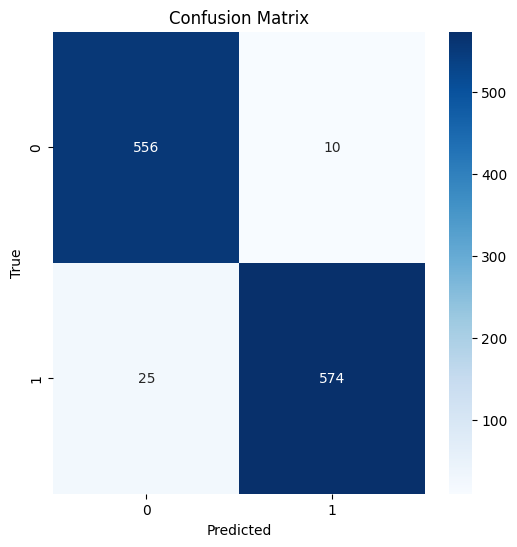

Metrics:
      Metric                                              Score
0   Accuracy  {'Naive Bayes': 0.984549356223176, 'LGM': 0.98...
1  Precision                                           0.982877
2     Recall                                           0.958264


In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall'],
    'Score': [accuracy, precision, recall]
})

# Display Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
print("Metrics:")
print(metrics_df)